# Problem Recognition
- Apply Fast Shapelets on ECG200 dataset

# Set Environment

In [0]:
# Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.markers import MarkerStyle


# Import Local package
import sys
sys.path.append('../other')
sys.path.append('..')

# Dataset
from tslearn.datasets import UCR_UEA_datasets
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax

# Fast Shapelets
from sax import SAXExtractor
import other_util 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from shapelet_tree import ShapeletTreeClassifier
from shapelet_tree import extract_shapelets_with_tree
from shapelet_tree import ShapeletTransformer


# Evaluation
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve

# Save Results
import time
from sklearn.externals import joblib
import pickle 


import warnings; warnings.filterwarnings('ignore')

# Data Preparation

In [0]:
# Import Data from UCR repository
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset('ECG200')

X_train = TimeSeriesScalerMinMax().fit_transform(X_train)
X_test = TimeSeriesScalerMinMax().fit_transform(X_test)

# Reshape for match the scikit-learn data structure
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

# Map labels to [0, .., C-1]
# After map, 0 is abnormal class, 1 is normal class
map_dict = {}
for j, c in enumerate(np.unique(y_train)):
    map_dict[c] = j
y_train = pd.Series(y_train).map(map_dict).values
y_test = pd.Series(y_test).map(map_dict).values

# Model Fitting

In [0]:
# Initial fast shapelet model
extractor = SAXExtractor(alphabet_size=4, sax_length=16, nr_candidates=10, 
                          iterations=5, mask_size=3)

# Initial shapelets tree classifier
st_clf = ShapeletTreeClassifier(method=extractor, 
                                min_len=16,
                                max_len=60, 
                                max_depth = 1,
                                min_samples_split = 2,
                                metric=other_util.calculate_ig)
# Fitting Model
st_clf.fit(X_train,y_train)

# Evaluation

In [0]:
fs_perform_list = []
y_pred = st_clf.tree.predict(X_test)
acc = accuracy_score(y_test,y_pred)
cm = confusion_matrix(y_test,y_pred)
prfs = precision_recall_fscore_support(y_test,y_pred)
fs_perform_list.append([acc,cm,prfs])
df_metrix = pd.DataFrame(data=fs_perform_list,columns=['Accuracy','TP','FN','FP','TN','Precision','Recall','Fscore'],index=modelname_list)

# Save Result
timestr = time.strftime("%Y%m%d-%H%M")
output = '../output'
path = join(output,'ecg200_fs_performance.csv')
df_metrix.to_csv(path)


In [0]:
# Save Result
timestr = time.strftime("%Y%m%d-%H%M")
path = join(PROJECT_PATH,'base_metric.csv')
#fs_metrix.to_csv(path)


# Visualization

In [0]:
# The Fast Shapelet Transform
def calculate_distance_matrix(X, shapelets):
    D = np.zeros((len(X), len(shapelets)))
    for smpl_idx, sample in enumerate(X):
        for shap_idx, shapelet in enumerate(shapelets):
            dist = other_util.sdist_no_norm(shapelet.flatten(), sample)
            D[smpl_idx, shap_idx] = dist
    return D

# Transform Train and Test datasets to the distance with shapelets
tree_shp = st_clf.tree.extract_all_shapelets()
shp_tree = [np.array(x) for x in tree_shp]
X_train_fs = calculate_distance_matrix(X_train,shp_tree)
X_test_fs = calculate_distance_matrix(X_test,shp_tree)

#The most close time series id 
ts_id = np.argmin(X_train_fs,axis=0)
ts = X_train[ts_id[0]]
shp = shp_tree[0]

# get the positon of the shapelets in the time series
md,pos = other_util.sdist_with_pos(ts,shp)

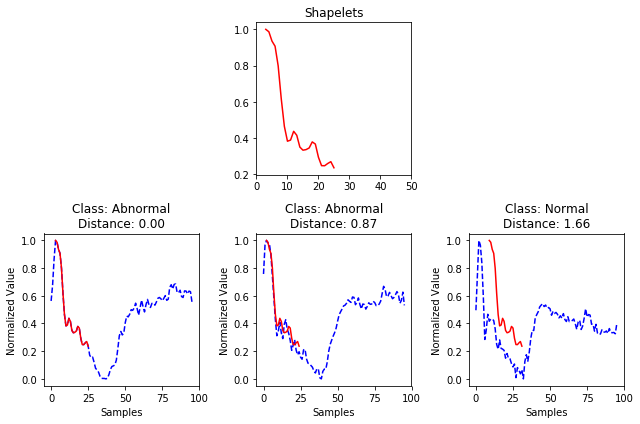

In [0]:
fig = plt.figure(figsize=[9,6])
gs = GridSpec(2, 3, figure=fig)
colors = ['r', 'b', 'g', 'y', 'c', 'm']

#ax1: shapelet with best match
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(range(pos,pos+len(shp)),shp,c='r')
ax1.set_xlim(0,50)
ax1.set_title("Shapelets")


#ax2: shapelt with closest time  
ax2 = fig.add_subplot(gs[1,0])

## Good Match ts
bst_ts = X_train[bst_shp[3]]
ax2.plot(range(len(bst_ts)),bst_ts,ls = '--',c='b',label='Near')
ax2.plot(range(pos,pos+len(shp)),shp,c='r')
ax2.set_title("Class: Abnormal\nDistance: {:.2f}".format(0.0))
ax2.set_xlabel("Samples")
ax2.set_ylabel("Normalized Value")


#ax3:OK match ts:85
ax3 = fig.add_subplot(gs[1,1])
ok_ts = X_train[85]
min_dist,location  = other_util.sdist_with_pos(y_bs,ok_ts)
ax3.plot(range(len(ok_ts)),ok_ts,ls = '--',c='b',label = 'Middle')
ax3.plot(range(location,location+len(shp)),shp,c='r')
ax3.set_title("Class: Abnormal\nDistance: {:.2f}".format(min_dist))
ax3.set_xlabel("Samples")
ax3.set_ylabel("Normalized Value")


#ax4: Bad Match ts:82
ax4 = fig.add_subplot(gs[1,2])
bad_ts = X_train[82]
min_dist,location  = other_util.sdist_with_pos(shp,bad_ts)
ax4.plot(range(len(bad_ts)),bad_ts,ls = '--',c='b',label='Far')
ax4.plot(range(location,location+len(shp)),y_bs,c='r')
ax4.set_title("Class: Normal\nDistance: {:.2f}".format(min_dist))
ax4.set_xlabel("Samples")
ax4.set_ylabel("Normalized Value")

plt.tight_layout()

# Save Figure
timestr = time.strftime("%Y%m%d-%H%M")
fig_name = "".join((PROJECT_PATH,"/ECG200_Shapelets_",timestr,".png"))
plt.savefig(fig_name,dpi=100)


plt.show()